In [747]:
using Plots
using LinearAlgebra

### Tensor initialisieren

In [748]:
#weightfunction
function weight(beta::Float64, s1::Int, s2::Int)
    return exp(beta/2 *s1 * s2)  
end

weight (generic function with 1 method)

In [749]:
# initialization
function tensor_init(beta::Float64)
    
        s1 = s2 = s3 = s4 = Int[-1,1]
        tensor = zeros(Float64,2,2,2,2)
    
    for   l in 1:2, k in 1:2,  j in 1:2, i in 1:2
        tensor[i,j,k,l] = weight(beta, s1[i], s2[j])*weight(beta, s2[j], s3[k])*weight(beta, s3[k], s4[l])*weight(beta, s4[l], s1[i])
    end

    return tensor
end

tensor_init (generic function with 1 method)

In [750]:
# Test
tensor = tensor_init(1.0)

2×2×2×2 Array{Float64,4}:
[:, :, 1, 1] =
 7.38906  1.0
 1.0      1.0

[:, :, 2, 1] =
 1.0       1.0
 0.135335  1.0

[:, :, 1, 2] =
 1.0  0.135335
 1.0  1.0     

[:, :, 2, 2] =
 1.0  1.0    
 1.0  7.38906

### SVD + Zusammenkleben

In [751]:
# Trennung g_1, g_3 durch Verdopplung und Trennung g_2,g_4

function split(tensor)
    
    #rearranging 
    tensor_sort = zeros(Float64,2,2,2,2)
    for i in 1:2, k in 1:2, j in 1:2, l in 1:2
        tensor_sort[i,k,j,l] = tensor[i,j,k,l]
    end
    
    #println(" \n\nTensor umstrukturiert s1_s3:\n",round.(tensor_sort, digits = 5))
    
    # SVD and triangle amplitudes
    S1 = zeros(Float64,2,2,2) 
    S2 = zeros(Float64,2,2,2)
    
    # larger singular values sigma^1
    SValues_first = Float64[]
    # smaller singular values sigma^2 
    SValues_sec = Float64[]
    
    for  j in 1:2, l in 1:2
        F = svd(tensor_sort[:,:,j,l])
        SValues_first = append!(SValues_first, F.S[1])
        SValues_sec = append!(SValues_sec, F.S[2])
        
        for g in 1:2
                 S1[j,l,g] = F.U[g,1]*sqrt(F.S[1])/sqrt(SValues_first[1])
                 S2[j,l,g] = F.Vt[1,g]*sqrt(F.S[1])/sqrt(SValues_first[1])
        end    
    end 
      
    #Nomalisation 
    SValues_sec = SValues_sec/SValues_first[1]
    SValues_first = SValues_first/SValues_first[1]
    
    S3 = S1
    S4 = S2

    return S1, S2, S3, S4, SValues_first, SValues_sec
    
end

split (generic function with 1 method)

In [752]:
#Test
S1, S2, S3, S4, SValues_first, Svalues_sec = split(tensor)

([-0.9909660892472092 -0.3645560511321131; -0.36455605113211287 -0.1341126763661493]

[-0.13411267636614946 -0.3645560511321131; -0.3645560511321131 -0.9909660892472091], [-0.9909660892472094 -0.3645560511321131; -0.3645560511321131 -0.13411267636614946]

[-0.13411267636614949 -0.364556051132113; -0.364556051132113 -0.9909660892472094], [-0.9909660892472092 -0.3645560511321131; -0.36455605113211287 -0.1341126763661493]

[-0.13411267636614946 -0.3645560511321131; -0.3645560511321131 -0.9909660892472091], [-0.9909660892472094 -0.3645560511321131; -0.3645560511321131 -0.13411267636614946]

[-0.13411267636614949 -0.364556051132113; -0.364556051132113 -0.9909660892472094], [1.0, 0.2658022288340796, 0.2658022288340796, 0.9999999999999998], [3.655423120042796e-18, 2.0866703749686375e-17, 2.0866703749686375e-17, 1.5830647145620937e-17])

In [753]:
#Gluing 
function glue(S1,S2,S3,S4)
    
    tensor_eff = zeros(Float64,2,2,2,2)
    A = zeros(Float64,2,2,2,2)
    B = zeros(Float64,2,2,2,2)
    
    #glueing of the triangle amplitudes
    for p in 1:2, q in 1:2, r in 1:2, s in 1:2
            for g in 1:2
                tensor_eff[p,q,r,s] += S1[q,r,g] * S2[p,s,g] * S3[s,r,g] * S4[p,q,g]
                if tensor_eff[p,q,r,s] <= 10^(-10)
                   tensor_eff[p,q,r,s] = 0
                end
        end 
        end 
    
    # condition to obtain a stable algorithm (see appendix)
     if tensor_eff[1,1,1,1] != tensor_eff[2,2,2,2]
            tensor_eff[2,2,2,2] = tensor_eff[1,1,1,1]
        end

    if  (tensor_eff[1,1,1,2] != tensor_eff[1,1,2,1] || tensor_eff[1,1,1,2]   != tensor_eff[1,2,1,1]|| tensor_eff[1,1,1,2]   != tensor_eff[2,1,1,1])
            tensor_eff[1,1,2,1] = tensor_eff[1,1,1,2]
            tensor_eff[1,2,1,1] = tensor_eff[1,1,1,2]         
            tensor_eff[2,1,1,1] = tensor_eff[1,1,1,2]
            
    end
    if  (tensor_eff[1,1,1,2] != tensor_eff[2,2,2,1] || tensor_eff[1,1,1,2]   != tensor_eff[2,1,2,2]|| tensor_eff[1,1,1,2]   != tensor_eff[2,2,1,2]|| tensor_eff[1,1,1,2]   != tensor_eff[1,2,2,2])
            tensor_eff[2,2,2,1] = tensor_eff[1,1,1,2]
            tensor_eff[1,2,2,2] = tensor_eff[1,1,1,2]         
            tensor_eff[2,1,2,2] = tensor_eff[1,1,1,2]
            tensor_eff[2,2,1,2] = tensor_eff[1,1,1,2]
            
    end
    
    if (tensor_eff[1,1,2,2] != tensor_eff[2,2,1,1]) || (tensor_eff[1,1,2,2]!= tensor_eff[2,1,1,2]) ||(tensor_eff[1,1,2,2]!= tensor_eff[1,2,2,1])
            tensor_eff[2,2,1,1] = tensor_eff[1,1,2,2]
            tensor_eff[2,1,1,2] = tensor_eff[1,1,2,2]         
            tensor_eff[1,2,2,1] = tensor_eff[1,1,2,2]
    end
    
    if tensor_eff[1,2,1,2] != tensor_eff[2,1,2,1]
            tensor_eff[2,1,2,1] = tensor_eff[1,2,1,2]
    end
    
    return tensor_eff
end  

glue (generic function with 1 method)

In [754]:
#test
tensor_eff = glue(S1,S2,S3,S4)

2×2×2×2 Array{Float64,4}:
[:, :, 1, 1] =
 0.964675  0.132901 
 0.132901  0.0353254

[:, :, 2, 1] =
 0.132901   0.0353254
 0.0353254  0.132901 

[:, :, 1, 2] =
 0.132901   0.0353254
 0.0353254  0.132901 

[:, :, 2, 2] =
 0.0353254  0.132901
 0.132901   0.964675

## LES Couplings

In [755]:
function LSE_coupling(tensor)
    A = Float64[2 2 1 1; -2 2 1 1; 0 -2 1 1; 0 0 -1 1]
    A_inv = inv(A)
    tensor_vec = zeros(Float64, 4)
    
    tensor_vec[1] = log(tensor[1,1,1,1]) 
    tensor_vec[2] = log(tensor[2,1,2,1]) 
    tensor_vec[3] = log(tensor[2,2,1,1])
    tensor_vec[4] = log(tensor[2,1,1,1])
    LSE_Couplings = A_inv*tensor_vec

    return LSE_Couplings
end  

LSE_coupling (generic function with 1 method)

In [756]:
#test
LSE_coupling(tensor_eff)

4-element Array{Float64,1}:
  0.8267970564532376 
  0.4133985282266188 
 -0.24910284545231343
 -2.2672527733701244 

### Hauptprogramm

In [757]:
#Main
function main(iterations::Int, beta::Float64)
    
    tensor = tensor_init(beta)
    #println("\nTensor0:\n", round.(tensor,digits = 4))
    SV_first = zeros(iterations, 2)
    SV_sec  = zeros(iterations, 2)
    Couplings = zeros(iterations, 4)
    
    LGS_Couplings = LSE_coupling(tensor) # hier nochmal überlegen ob das da hingehört
    for i in 1 : iterations
        
        
        (S1,S2,S3,S4, SValues_first, SValues_sec) = split(tensor)
        tensor = glue(S1, S2, S3, S4)
        
        #println("\nTensor", i, ":\n", round.(tensor,digits = 4))
        # array for the larger singular values sigma^1
        SV_first[i,1] = SValues_first[1]
        SV_first[i,2] = SValues_first[2]
        
        # array for the smaller singular values sigma^2
        SV_sec[i,1] = SValues_sec[1]
        SV_sec[i,2] = SValues_sec[2]
        
        # array for the coupling constants
        LSE_Couplings = LSE_coupling(tensor)
        for j = 1:4
            Couplings[i,j] = LSE_Couplings[j] 
        end
        # println("\n\n LSE:", LSE_val)
    end
    
    return SV_first, SV_sec , Couplings
end

main (generic function with 1 method)

In [758]:
#Test
s , p , c = main(5, 1.0)

([1.0 0.2658022288340796; 1.0 0.1710824914216769; … ; 1.0 0.06705965475983862; 1.0 0.03756295508293541], [3.655423120042796e-18 2.0866703749686375e-17; 0.016976897946122897 0.09923223472517091; … ; 0.003140058776538117 0.046824857476282046; 0.0011216412353167204 0.02986030339839462], [0.8267970564532376 0.4133985282266188 -0.24910284545231343 -2.2672527733701244; 1.0464562348366062 0.40458718143775574 -0.2409356630137065 -2.699692276398765; … ; 1.5227363519545547 0.6281813533121738 -0.4565313444502108 -3.8518512111953402; 1.8135851073278701 0.760269057942021 -0.5875524263178564 -4.5624365582852136])

### Renormalisation group flow of the singular value sigma^1_21

In [759]:
# Plots

function plotpt(iterations, beta1, beta2,beta3, beta4, beta5, beta6, beta7, beta8)
    
    SV_first1, SV_sec1 , Couplings1 = main(iterations, beta1)
    SV_first2, SV_sec2 , Couplings2 = main(iterations, beta2)
    SV_first3, SV_sec3 , Couplings3 = main(iterations, beta3)
    SV_first4, SV_sec4 , Couplings4 = main(iterations, beta4)
    SV_first5, SV_sec5 , Couplings5 = main(iterations, beta5)
    SV_first6, SV_sec6 , Couplings6 = main(iterations, beta6)
    SV_first7, SV_sec7 , Couplings7 = main(iterations, beta7)
    SV_first8, SV_sec8 , Couplings8 = main(iterations, beta8)
  
    y = [SV_first1[:,2], SV_first2[:,2], SV_first3[:,2], SV_first4[:,2],SV_first5[:,2], SV_first6[:,2], SV_first7[:,2], SV_first8[:,2]]
    
    plot([1:iterations],y, linewidth = 2, 
        guidefontsize = 12, ylabel = "Singular value \U03C3",
        legendfont=10,legend = :best, 
        label = ["\U003B2 = "*string(beta1) "\U003B2 = "*string(beta2) "\U003B2 = "*string(beta3) "\U003B2 = "*string(beta4) "\U003B2 = "*string(beta5) "\U003B2 = "*string(beta6) "\U003B2 = "*string(beta7) "\U003B2 = "*string(beta8)])
    plot!(xlims=(0,iterations),xticks=0:iterations/10:iterations, tickfontfamily=font("Times")) 
    plot!(ylims=(0,1),yticks=0:0.2:1) 
    plot!(xlabel="Iteration step")
    #savefig("C:/Users/Anna Rockstroh/Documents/Studium/5 Bachelorarbeit/BA Text/first_SV_"*string(beta1)*".pdf") 
end

plotpt (generic function with 1 method)

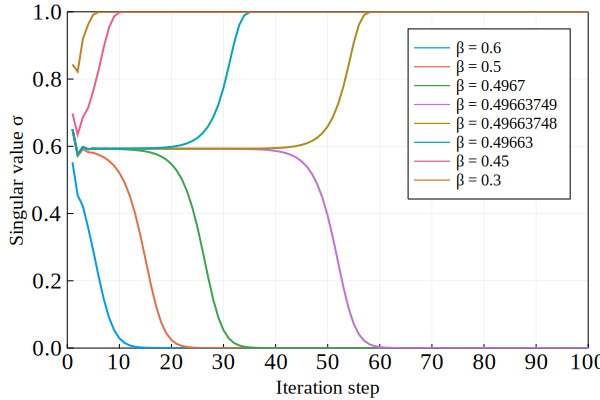

In [760]:
#Plotten für zwei Temperaturen und eine bestimmte Zahl an Iterationen
plotpt(100,0.6,0.5,0.4967,0.49663749,0.49663748,0.49663,0.45,0.3) #  0.4966374  0.4966374, 0.49663749: wird unsymetrisxh bei tensor 36
# beste symmetrieergebnisse ohne reduzierung derdezimalstelle

### Renormalisation group flow of the smaller singularvalues sigma^1_C

In [761]:
# Plots

function plot_svsec1(iterations, beta1, beta2,beta3, beta4, beta5)
    
    SV_first1, SV_sec1 , Couplings1 = main(iterations, beta1)
    SV_first2, SV_sec2 , Couplings2 = main(iterations, beta2)
    SV_first3, SV_sec3 , Couplings3 = main(iterations, beta3)
    SV_first4, SV_sec4 , Couplings4 = main(iterations, beta4)
    SV_first5, SV_sec5 , Couplings5 = main(iterations, beta5)
    
    y = [SV_sec1[:,1], SV_sec2[:,1],SV_sec3[:,1], SV_sec4[:,1],SV_sec5[:,1]]
    
    plot([1:iterations],y,
        guidefontsize = 14,linewidth = 2, legend = :best,  
        guidefontfamily=font("Times"), 
        label = ["\U003B2 = "*string(beta1) "\U003B2 = "*string(beta2) "\U003B2 = "*string(beta3) "\U003B2 = "*string(beta4) "\U003B2 = "*string(beta5)]
        , xlabel = "Iteration step", 
        ylabel = "Singular value \U03C3",legendfont=12, tickfontsize=12)

end

plot_svsec1 (generic function with 1 method)

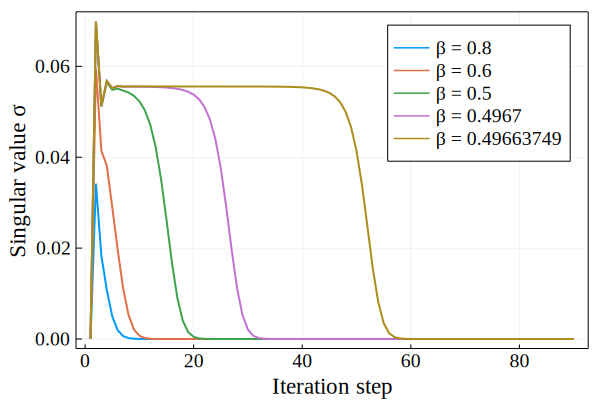

In [762]:
plot_svsec1(90,0.8,0.6,0.5,0.4967,0.49663749)  #zw. 0.4966374 und 0.4966375 Phasenpbergang; 0.496637480.49663749 Wechsel

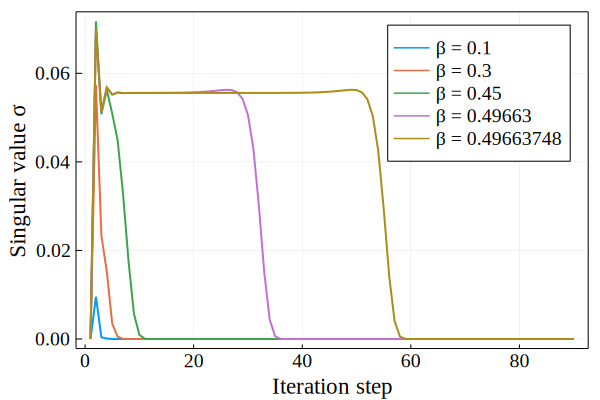

In [763]:
plot_svsec1(90,0.1,0.3,0.45,0.49663,0.49663748)

In [764]:
function plot_svsec2(iterations, beta1, beta2,beta3, beta4,beta5)
    
    SV_first1, SV_sec1 , Couplings1 = main(iterations, beta1)
    SV_first2, SV_sec2 , Couplings2 = main(iterations, beta2)
    SV_first3, SV_sec3 , Couplings3 = main(iterations, beta3)
    SV_first4, SV_sec4 , Couplings4 = main(iterations, beta4)
    SV_first5, SV_sec5 , Couplings5 = main(iterations, beta5)
    
    y = [SV_sec1[:,2], SV_sec2[:,2],SV_sec3[:,2], SV_sec4[:,2],SV_sec5[:,2]]
    
    plot([1:iterations],y,guidefontsize = 14, 
        linewidth = 2, legend = :best,legendfont=12,
        tickfontsize=12, guidefontfamily=font("Times"), 
        label = ["\U003B2 = "*string(beta1) "\U003B2 = "*string(beta2) "\U003B2 = "*string(beta3) "\U003B2 = "*string(beta4) "\U003B2 = "*string(beta5)]
        , xlabel = "Iteration step", ylabel = "Singular value \U03C3")

end

plot_svsec2 (generic function with 1 method)

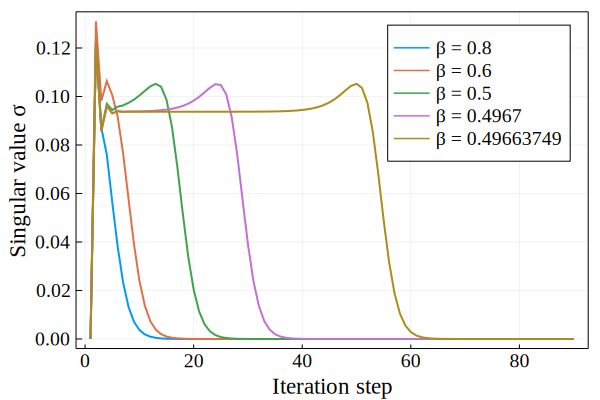

In [765]:
plot_svsec2(90,0.8,0.6,0.5,0.4967,0.49663749)

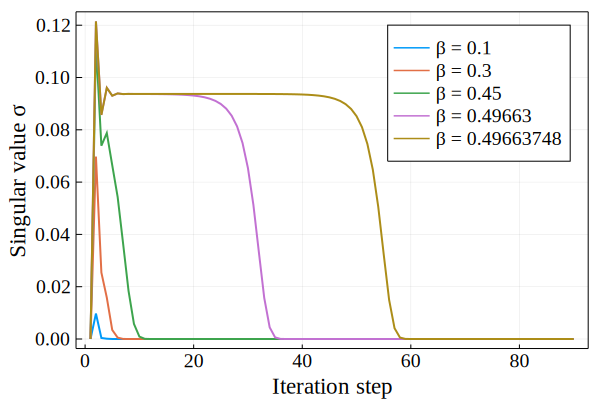

In [766]:
plot_svsec2(90,0.1,0.3,0.45,0.49663,0.49663748)

### Renormierungsgruppenfluss der Kopplungskonstanten

In [767]:
# plotfunktion für a,b,c,d,beta aus LGS

function plotabcd(iterations, beta1)
    
     SV_first, SV_sec , Couplings = main(iterations, beta1)
    
    y = [Couplings[:,1], Couplings[:,2], Couplings[:,3], Couplings[:,4]] 
    
    plot([1:iterations],y, linewidth = 2, 
    guidefontsize = 14,tickfontsize=12,legendfont=14, guidefontfamily=font("Times"),
        label = ["a" "b" "c" "d"],  legend = :bottomleft, xlabel =  "Iteration step", 
        ylabel = "coupling constants a,b,c,d" )
    
end 


plotabcd (generic function with 1 method)

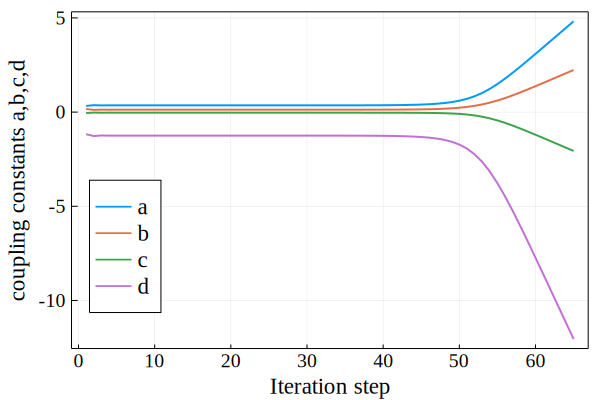

In [768]:
plotabcd(65,0.49663749) 

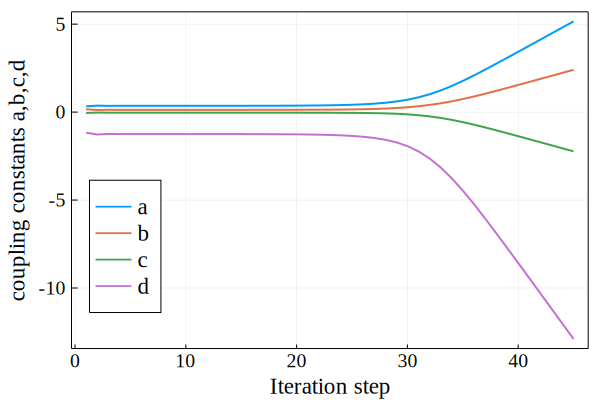

In [769]:
plotabcd(45,0.49665)  #0.49663
# werte gehen gegen 0, außer der Konstande Term - große Temperatur 
# - keine Wchselwirkung zwischen den Teilchen

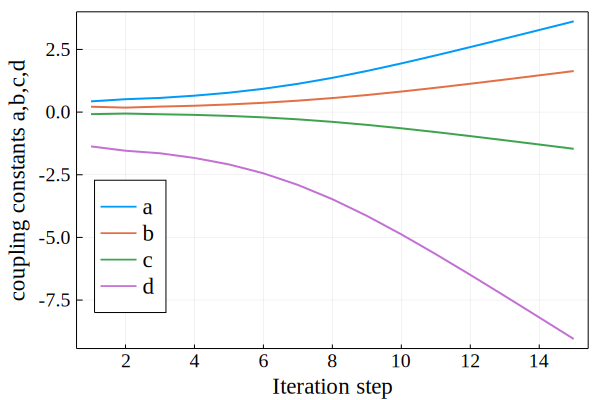

In [770]:
plotabcd(15,0.6)#ta, desto zeitiger divergiert es, weil die Werte im Tensor gegen 0 gehen und der Logarithmus gegen unendlich
# größe WW auch zwischen weit entfernten Spins 

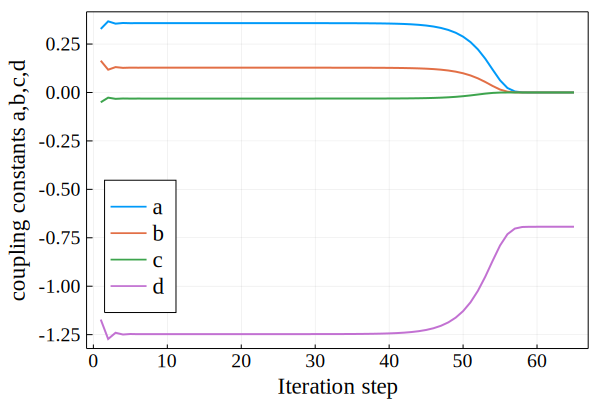

In [771]:
plotabcd(65,0.49663748)
# a = 0.3577 b = 0.1282 c = -0.0315 d=-1.2466

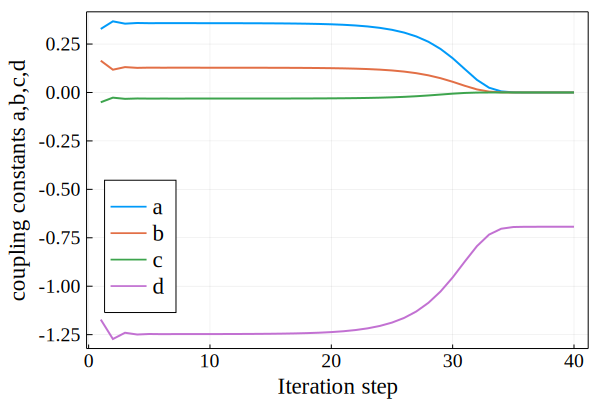

In [772]:
plotabcd(40,0.49663)
# hier erkennt man wieder das bei mehr als 50 Iterationen der Tensor wieder wächst und dann das LGS wieder lösbar wird

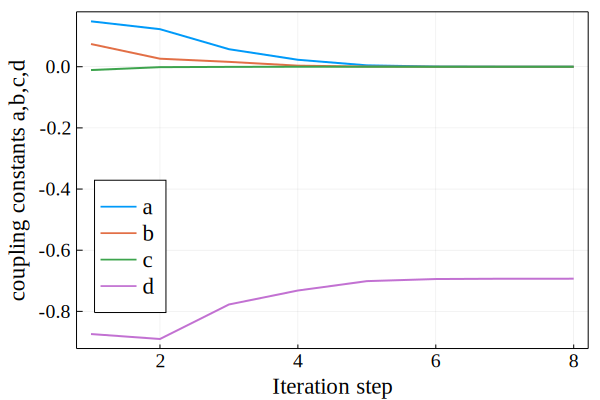

In [773]:
plotabcd(8,0.3)

### Renormalisation group flow equations analytically

In [774]:
# Renormalisation flow formulas
function constren(a::Float64,b::Float64,c::Float64,d::Float64)
   
    p = (1/4)*log(exp(-2*(-b + c))*
      sech(b - c)^2*
        (1 + 2*exp(4*(b + c))*sinh(2*a)^2)*
        (1 + exp(4*(b + c))*cosh(4*a) + 2*exp(2*(b + c))*cosh(2*a)*sqrt(1 + exp(4*(b + c))*sinh(2*a)^2))/
        (4 + 4*exp(4*(b + c))*sinh(2*a)^2))
    
    q = 1/4*log(sqrt((1 + 3*exp(4*(b + c))*sinh(2 *a)^2 + 
         2*exp(8*(b + c))*sinh(2*a)^4)*(1 + exp(4*(b + c))*cosh(4*a) + 
         2*exp(2*(b + c))*cosh(2*a)* sqrt(1 + exp(4*(b + c))*sinh(2*a)^2)))/
            (1 + exp(4*(b + c))*sinh(2*a)^2 + 
     exp(2*(b + c))*cosh(2*a)*sqrt(1 + exp(4*(b + c))*sinh(2*a)^2)))
    
    r = 1/4 *log(sqrt(1 + 2 *exp(4*(b + c))*sinh(2*a)^2)* 
        (1 + exp(4*(b + c))*sinh(2*a)^2 + exp(2*(b + c))*cosh(2*a)*sqrt(1 + exp(4*(b + c))*sinh(2*a)^2))/
        ((1 + exp(4*(b + c))*sinh(2*a)^2)^(3/2)*
            sqrt(1 + exp(4*(b + c))*cosh(4*a) + 2*exp(2*(b + c))*cosh(2*a)*sqrt(1 + exp(4*(b + c))*sinh(2*a)^2))))
    
   s = 1/4*log((exp(4 *(-b + c))*
        cosh(b - c) ^4*(1 + 2*exp(4*(b + c))*sinh(2*a)^2)^(1/2)*(1 + 
         exp(4*(b + c))*sinh(2*a)^2 + 
         exp(2*(b + c))*cosh(2*a)*sqrt(
          1 + exp(4*(b + c))*sinh(2*a)^2) ))/((1 + 
          exp(4*(b + c))*sinh(2*a)^2)^(3/2)*(1 + 
          exp(4*(b + c))*cosh(4*a) + 
          2*exp(2*(b + c))*cosh(2*a)*sqrt(
           1 + exp(4*(b + c))*sinh(2*a)^2))^(5/2)))

    return p,q,r,s
end

constren (generic function with 1 method)

In [775]:
# Iterative algorithm 
function renflow(a::Float64,b::Float64,c::Float64,d::Float64,iterations::Int)
    constantsren = zeros(iterations, 4)
    for i in 1:iterations
        a,b,c,d = renormierung(a,b,c,d)
        constantsren[i,1] = a
        constantsren[i,2] = b
        constantsren[i,3] = c
        constantsren[i,4] = d
    end
    return constantsren
end

renflow (generic function with 1 method)

In [776]:
# plot comparison of numerical and analytical parts
function plotvgl(a,b,c,d,iterations::Int,beta1)
    
    c = renflow(a,b,c,d,iterations)
    
    SV_first, SV_sec , Couplings = main(iterations, beta1)

    y1 = [Couplings[:,1], Couplings[:,2],Couplings[:,3], Couplings[:,4]] 
    y2 = [c[:,1], c[:,2],c[:,3], c[:,4]]
    
    plot([1:iterations],y2,  guidefontsize = 16,
        legendfont=11, guidefontfamily=font("Times"), label = ["a_a " "b_a " "c_a " "d_a "]
        , xlabel = "Iterations", ylabel = "constant", linewidth = 2)
    plot!([1:iterations],y1, label = ["a_n" "b_n" "c_n" "d_n"],  legend = :bottomleft, xlabel =  "Iteration step", ylabel = "Value of a,b,c,d" )

end

plotvgl (generic function with 1 method)

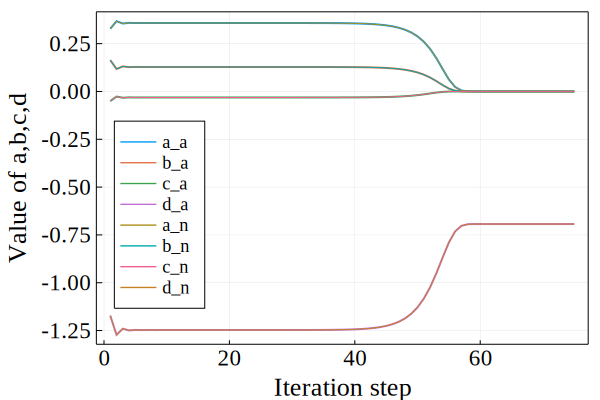

In [777]:
plotvgl(0.49663748,0.0,0.0,0.0,75,0.49663748)

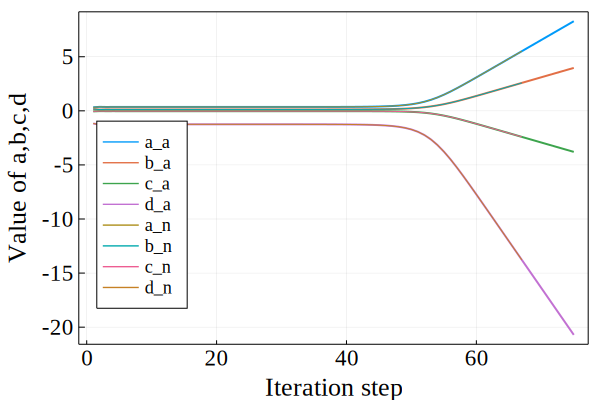

In [778]:
plotvgl(0.49663749,0.0,0.0,0.0,75,0.49663749)

In [779]:
# plot theorieraum
function plottheorieab(a1,b1,c1,d1,a2,b2,c2,d2,iterations::Int)
    
    c1 = renflow(a1,b1,c1,d1,iterations)
    c2 = renflow(a2,b2,c2,d2,iterations)

    plot(c1[:,1],c1[:,2], guidefontsize = 16,tickfontsize=13,
        legendfont=12, guidefontfamily=font("Times"), legend=:bottomright, 
        xlabel = "constant a", ylabel = "constant b", label = "b(a), a = "*string(a1))
    plot!(c1[:,1],c1[:,2],seriestype = :scatter, label = " ")
    plot!(c2[:,1],c2[:,2], label = "b(a), a = "*string(a2))
    plot!(c2[:,1],c2[:,2],seriestype = :scatter, label = " ")
    plot!([0.36],[0.13],seriestype = :scatter, label = "Instable fixed point")
    plot!(xlims=(-0.1,1),xticks=-0.3:0.1:1) 
    plot!(ylims=(-0.1,0.34),yticks=-1.0:0.05:0.8)  
    
    
end

plottheorieab (generic function with 1 method)

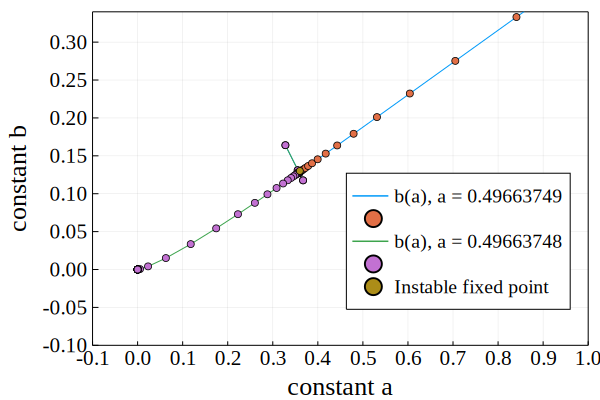

In [780]:
plottheorieab(0.49663749,0.0,0.0,0.0,0.49663748,0.0,0.0,0.0,75)

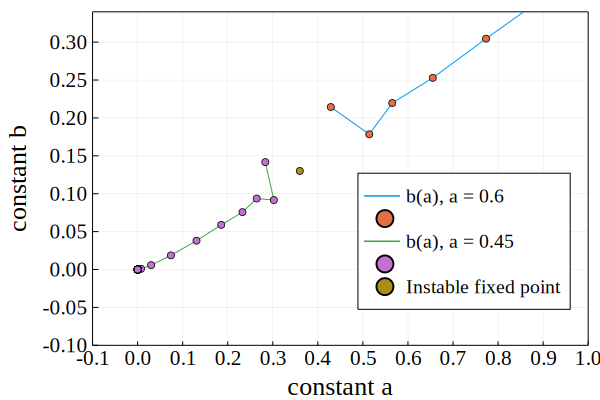

In [781]:
plottheorieab(0.6,0.0,0.0,0.0,0.45,0.0,0.0,0.0,75)